In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 15.4 MB/s 
     |████████████████████████████████| 895 kB 56.8 MB/s 
     |████████████████████████████████| 61 kB 636 kB/s 
     |████████████████████████████████| 3.3 MB 52.7 MB/s 
     |████████████████████████████████| 596 kB 72.8 MB/s 
     |████████████████████████████████| 1.2 MB 13.7 MB/s 


In [ ]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, HTML

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [ ]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(40,9601)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [ ]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(48000+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [ ]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [ ]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [ ]:
def get_metrics(actual, predicted, average='weighted'):
  return f1_score(actual, predicted, average=average), precision_score(actual, predicted, average=average), recall_score(actual, predicted, average=average)

In [ ]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        test_lbls, test_preds,
                        average='micro', pos_label=1):
    f1, p, r = get_metrics(train_labels, train_predictions, average=average)
    results['train_precision'].append(p)
    results['train_recall'].append(r)
    results['train_f1'].append(f1)
    f1, p, r = get_metrics(validation_labels, validation_predictions, average=average)
    results['validation_precision'].append(p)
    results['validation_recall'].append(r)
    results['validation_f1'].append(f1)
    f1, p, r = get_metrics(test_lbls, test_preds, average=average)
    results['test_precision'].append(p)
    results['test_recall'].append(r)
    results['test_f1'].append(f1)
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['test_labels'].append([test_lbls])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    results['test_predictions'].append([test_preds])
    return results

In [ ]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [ ]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'

    def subplot_routine(key1, key2, title, loss=False, key3=None):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        if key3:
          plt.plot([x for k in results for x in results[k][key3]])
        plt.grid()
        plt.xlabel(x_label)
        if key3:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val','Test']])
        else:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val']])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    plt.subplot(2,1,1)
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2,1,2)
    subplot_routine('train_f1', 'validation_f1', 'F1', key3='test_f1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [ ]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [ ]:
def load_tx_model(rootpath):
  return AutoModel.from_pretrained(os.path.join(rootpath,'pytorch_model.bin'), local_files_only=True,
                                  config=AutoConfig.from_pretrained(os.path.join(rootpath,'config.json')))

In [ ]:
def predict_test_data(model, chkpoint, test_data, gpu, feature='mel_spec', target='RagamCode'):
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, masks = get_seq_masks(chkpoint, txt)
  model = model.to(gpu)
  ds = FusionDataset(sequences, masks, test_data[feature].tolist(), test_data[target].tolist())
  model.eval()
  preds, truth = [], []
  for step, batch in enumerate(ds.get_data_loader(16)):
    batch = [r.to(gpu) for r in batch]
    sequences, masks, features, labels = batch
    with torch.no_grad():
      preds_batch = model(sequences, masks, features)
    preds_batch = preds_batch.detach().cpu().numpy()
    preds.append(preds_batch)
    truth.append(labels.detach().cpu().numpy())
    del batch
  preds = np.concatenate(preds, axis=0)
  truth = np.concatenate(truth, axis=0)
  preds = np.argmax(preds, axis=1)
  return preds, truth

In [ ]:
def train_model(data, test_data, sequences, masks, rootpath, gpu, chkpoint, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    cv_score = {'train_predictions': [],
                'validation_predictions': [],
                'train_labels': [],
                'validation_labels': [],
                'test_predictions' : [],
                'test_labels' : []
                }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'test_predictions' :[],
                       'train_labels': [],
                       'validation_labels': [],
                       'test_labels' : []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'test_f1' : [],
            'train_precision': [],
            'validation_precision': [],
            'test_precision' :[],
            'train_recall': [],
            'validation_recall': [],
            'test_recall' :[],
            'train_labels': [],
            'validation_labels': [],
            'test_labels' : [],
            'train_predictions': [],
            'validation_predictions': [],
            'test_predictions':[]
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        transformer = load_tx_model(rootpath)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr),
                     torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.8)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            for lr_scheduler in lr_schedulers:
                lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            test_preds, test_lbls = predict_test_data(model, chkpoint, test_data, gpu, feature=feature, target=target)
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions,
                                             test_lbls, test_preds)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 test_lbls, test_preds,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions,
                                                test_lbls, test_preds)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model
        cv_score['train_labels'] = cv_score['train_labels'] + best_scores['train_labels'].tolist()
        cv_score['train_predictions'] = cv_score['train_predictions'] + best_scores['train_predictions'].tolist()
        cv_score['validation_labels'] = cv_score['validation_labels'] + best_scores['validation_labels'].tolist()
        cv_score['validation_predictions'] = cv_score['validation_predictions'] + best_scores['validation_predictions'].tolist()
        cv_score['test_labels'] = cv_score['test_labels'] + best_scores['test_labels'].tolist()
        cv_score['test_predictions'] = cv_score['test_predictions'] + best_scores['test_predictions'].tolist()
        print('*** Confusion Matrix - Testing ***')
        print(get_metrics(cv_score['test_labels'],cv_score['test_predictions']))
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))
    if plot:
        plot_results(results, title)
    cv_result = {}
    cv_result['validation_f1'], cv_result['validation_precision'], cv_result['validation_recall'] = get_metrics(cv_score['validation_labels'],cv_score['validation_predictions'])
    cv_result['test_f1'], cv_result['test_precision'], cv_result['test_recall'] = get_metrics(cv_score['test_labels'],cv_score['test_predictions'])
    cv_result['train_f1'], cv_result['train_precision'], cv_result['train_recall'] = get_metrics(cv_score['train_labels'],cv_score['train_predictions'])
    print('*** Cross Validation Score ***')
    cv_result = pd.DataFrame(cv_result, index=[0]) # Scalar values
    display(HTML(cv_result.to_html().replace("\\n", "<br>")))
    return results

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mels.pkl')
labels = torch.tensor(data['RagamCode'].tolist())
n_labels = len(data['RagamCode'].unique())
res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']

In [ ]:
# Held out 10% Data
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['RagamCode'], test_size=0.1, random_state=100)

test_data = data.loc[Y2.index]
data = data.loc[Y1.index]

txt = list(data.apply(lambda x: x.Lyric, axis=1))

# Fusion with IndicBERT and MEL Spectrogram

In [ ]:
def get_seq_masks(chkpoint, txt):
  tokenizer = AutoTokenizer.from_pretrained(chkpoint)
  all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
  sequences = torch.tensor(all_tokens['input_ids'])
  attention_masks = torch.tensor(all_tokens['attention_mask'])
  return sequences, attention_masks

In [ ]:
N_EPOCHS = 30

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.85416667 2.62820513 2.27777778 1.36666667 2.44047619 3.41666667
 1.13888889 1.31410256 0.85416667 1.79824561 1.5530303  3.41666667
 0.75925926 0.55107527 2.84722222 1.2654321  1.2654321  1.70833333
 1.89814815 2.27777778 0.69727891 0.62121212 0.39272031 1.5530303
 0.53385417 1.10215054 0.57909605 0.43803419 4.27083333 0.41666667]
Epoch 1/30 : Training Loss: 3.419 / Validation Loss : 3.397 [Time : 19.938794 seconds]
Epoch 2/30 : Training Loss: 3.397 / Validation Loss : 3.390 [Time : 19.969487 seconds]
Epoch 3/30 : Training Loss: 3.391 / Validation Loss : 3.384 [Time : 19.839528 seconds]
Epoch 4/30 : Training Loss: 3.384 / Validation Loss : 3.374 [Time : 19.931771 seconds]
Epoch 5/30 : Training Loss: 3.376 / Validation Loss : 3.365 [Time : 19.853645 seconds]
Epoch 6/30 : Training Loss: 3.366 / Validation Loss : 3.361 [Time : 19.922554 seconds]
Epoch 7/30 : Training Loss: 3.363 / Validation Loss : 3.358 [Time : 19.852174 seconds]
Epoch 8/30 : Training Loss: 3.348 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 12.755 / Validation Loss : 3.073 [Time : 19.814694 seconds]
Epoch 2/30 : Training Loss: 2.724 / Validation Loss : 1.129 [Time : 19.898949 seconds]
Epoch 3/30 : Training Loss: 1.228 / Validation Loss : 0.632 [Time : 19.664747 seconds]
Epoch 4/30 : Training Loss: 0.743 / Validation Loss : 0.380 [Time : 19.825489 seconds]
Epoch 5/30 : Training Loss: 0.442 / Validation Loss : 0.243 [Time : 19.644818 seconds]
Epoch 6/30 : Training Loss: 0.310 / Validation Loss : 0.167 [Time : 19.841609 seconds]
Epoch 7/30 : Training Loss: 0.196 / Validation Loss : 0.120 [Time : 19.903372 seconds]
Epoch 8/30 : Training Loss: 0.174 / Validation Loss : 0.111 [Time : 19.899934 seconds]
Epoch 9/30 : Training Loss: 0.175 / Validation Loss : 0.089 [Time : 19.822743 seconds]
Epoch 10/30 : Training Loss: 0.214 / Validation Loss : 0.124 [Time : 18.910827 seconds]
Epoch 11/30 : Training Loss: 0.143 / Validation Loss : 0.061 [Time : 19.914008 seconds]
Epoch 12/30 : Training Loss: 0.081 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.476 / Validation Loss : 3.403 [Time : 18.949963 seconds]
Epoch 2/30 : Training Loss: 3.421 / Validation Loss : 3.396 [Time : 18.947164 seconds]
Epoch 3/30 : Training Loss: 3.408 / Validation Loss : 3.393 [Time : 18.907851 seconds]
Epoch 4/30 : Training Loss: 3.408 / Validation Loss : 3.391 [Time : 18.964215 seconds]
Epoch 5/30 : Training Loss: 3.404 / Validation Loss : 3.385 [Time : 18.985924 seconds]
Epoch 6/30 : Training Loss: 3.395 / Validation Loss : 3.379 [Time : 18.923451 seconds]
Epoch 7/30 : Training Loss: 3.392 / Validation Loss : 3.375 [Time : 18.856302 seconds]
Epoch 8/30 : Training Loss: 3.386 / Validation Loss : 3.367 [Time : 18.915248 seconds]
Epoch 9/30 : Training Loss: 3.374 / Validation Loss : 3.360 [Time : 19.081131 seconds]
Epoch 10/30 : Training Loss: 3.372 / Validation Loss : 3.353 [Time : 18.870709 seconds]
Epoch 11/30 : Training Loss: 3.363 / Validation Loss : 3.343 [Time : 18.899832 seconds]
Epoch 12/30 : Training Loss: 3.352 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.439 / Validation Loss : 3.194 [Time : 18.925368 seconds]
Epoch 2/30 : Training Loss: 3.143 / Validation Loss : 2.996 [Time : 18.849352 seconds]
Epoch 3/30 : Training Loss: 2.927 / Validation Loss : 2.747 [Time : 19.082284 seconds]
Epoch 4/30 : Training Loss: 2.666 / Validation Loss : 2.456 [Time : 18.881426 seconds]
Epoch 5/30 : Training Loss: 2.362 / Validation Loss : 2.141 [Time : 18.885708 seconds]
Epoch 6/30 : Training Loss: 2.052 / Validation Loss : 1.828 [Time : 18.845881 seconds]
Epoch 7/30 : Training Loss: 1.752 / Validation Loss : 1.546 [Time : 18.848366 seconds]
Epoch 8/30 : Training Loss: 1.475 / Validation Loss : 1.291 [Time : 18.845647 seconds]
Epoch 9/30 : Training Loss: 1.234 / Validation Loss : 1.071 [Time : 18.854532 seconds]
Epoch 10/30 : Training Loss: 1.023 / Validation Loss : 0.888 [Time : 19.008079 seconds]
Epoch 11/30 : Training Loss: 0.851 / Validation Loss : 0.738 [Time : 18.917674 seconds]
Epoch 12/30 : Training Loss: 0.710 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 29.034 / Validation Loss : 5.451 [Time : 18.926335 seconds]
Epoch 2/30 : Training Loss: 4.628 / Validation Loss : 1.735 [Time : 18.861051 seconds]
Epoch 3/30 : Training Loss: 1.872 / Validation Loss : 0.690 [Time : 18.871106 seconds]
Epoch 4/30 : Training Loss: 0.872 / Validation Loss : 0.334 [Time : 18.880944 seconds]
Epoch 5/30 : Training Loss: 0.472 / Validation Loss : 0.208 [Time : 18.870739 seconds]
Epoch 6/30 : Training Loss: 0.350 / Validation Loss : 0.161 [Time : 18.84404 seconds]
Epoch 7/30 : Training Loss: 0.243 / Validation Loss : 0.120 [Time : 18.869061 seconds]
Epoch 8/30 : Training Loss: 0.220 / Validation Loss : 0.091 [Time : 18.991584 seconds]
Epoch 9/30 : Training Loss: 0.170 / Validation Loss : 0.060 [Time : 18.915979 seconds]
Epoch 10/30 : Training Loss: 0.116 / Validation Loss : 0.055 [Time : 18.889315 seconds]
Epoch 11/30 : Training Loss: 0.100 / Validation Loss : 0.042 [Time : 18.870353 seconds]
Epoch 12/30 : Training Loss: 0.075 / Vali

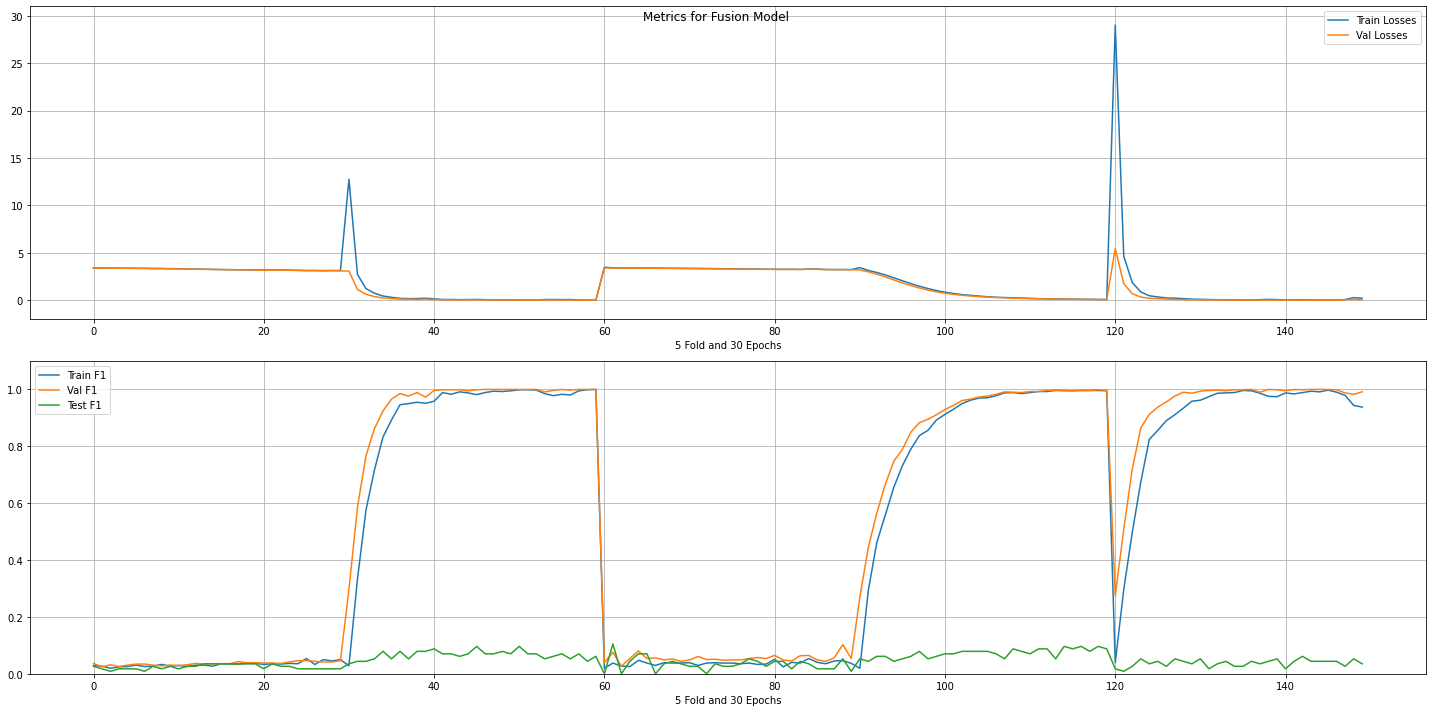

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.697939,0.880689,0.619756,0.045115,0.05168,0.045614,0.66449,0.786984,0.616341


In [ ]:
sequences, attention_masks = get_seq_masks('ai4bharat/indic-bert',txt)
indic_bert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/IndicBERT_FineTuned',
                                gpu, 'ai4bharat/indic-bert', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=N_EPOCHS, target='RagamCode', model=FusionModel, lr=1.11111e-5, mdlargs={'n_labels':n_labels})

In [ ]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
29,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404
20,0.998780,1.000000,0.096491,0.998780,1.000000,0.096491,0.998780,1.000000,0.096491
21,0.998780,1.000000,0.070175,0.998780,1.000000,0.070175,0.998780,1.000000,0.070175
28,0.998780,1.000000,0.043860,0.998780,1.000000,0.043860,0.998780,1.000000,0.043860
22,0.997561,1.000000,0.070175,0.997561,1.000000,0.070175,0.997561,1.000000,0.070175
25,0.997561,1.000000,0.043860,0.997561,1.000000,0.043860,0.997561,1.000000,0.043860
19,0.995122,1.000000,0.070175,0.995122,1.000000,0.070175,0.995122,1.000000,0.070175
27,0.995122,1.000000,0.070175,0.995122,1.000000,0.070175,0.995122,1.000000,0.070175
16,0.995122,1.000000,0.043860,0.995122,1.000000,0.043860,0.995122,1.000000,0.043860
17,0.993902,1.000000,0.070175,0.993902,1.000000,0.070175,0.993902,1.000000,0.070175


# MURIL Fusion

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.85416667 2.62820513 2.27777778 1.36666667 2.44047619 3.41666667
 1.13888889 1.31410256 0.85416667 1.79824561 1.5530303  3.41666667
 0.75925926 0.55107527 2.84722222 1.2654321  1.2654321  1.70833333
 1.89814815 2.27777778 0.69727891 0.62121212 0.39272031 1.5530303
 0.53385417 1.10215054 0.57909605 0.43803419 4.27083333 0.41666667]
Epoch 1/30 : Training Loss: 3.416 / Validation Loss : 3.395 [Time : 23.98629 seconds]
Epoch 2/30 : Training Loss: 3.397 / Validation Loss : 3.389 [Time : 23.773686 seconds]
Epoch 3/30 : Training Loss: 3.392 / Validation Loss : 3.384 [Time : 23.980967 seconds]
Epoch 4/30 : Training Loss: 3.385 / Validation Loss : 3.378 [Time : 23.808341 seconds]
Epoch 5/30 : Training Loss: 3.380 / Validation Loss : 3.372 [Time : 23.806713 seconds]
Epoch 6/30 : Training Loss: 3.373 / Validation Loss : 3.364 [Time : 23.794307 seconds]
Epoch 7/30 : Training Loss: 3.368 / Validation Loss : 3.362 [Time : 23.909064 seconds]
Epoch 8/30 : Training Loss: 3.365 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.428 / Validation Loss : 3.401 [Time : 19.662449 seconds]
Epoch 2/30 : Training Loss: 3.403 / Validation Loss : 3.398 [Time : 19.110924 seconds]
Epoch 3/30 : Training Loss: 3.400 / Validation Loss : 3.396 [Time : 19.096492 seconds]
Epoch 4/30 : Training Loss: 3.399 / Validation Loss : 3.394 [Time : 19.152178 seconds]
Epoch 5/30 : Training Loss: 3.398 / Validation Loss : 3.392 [Time : 19.113899 seconds]
Epoch 6/30 : Training Loss: 3.395 / Validation Loss : 3.392 [Time : 19.106467 seconds]
Epoch 7/30 : Training Loss: 3.396 / Validation Loss : 3.388 [Time : 19.143544 seconds]
Epoch 8/30 : Training Loss: 3.391 / Validation Loss : 3.386 [Time : 19.110891 seconds]
Epoch 9/30 : Training Loss: 3.391 / Validation Loss : 3.384 [Time : 19.101448 seconds]
Epoch 10/30 : Training Loss: 3.389 / Validation Loss : 3.382 [Time : 19.073802 seconds]
Epoch 11/30 : Training Loss: 3.387 / Validation Loss : 3.381 [Time : 19.134378 seconds]
Epoch 12/30 : Training Loss: 3.385 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 4.062 / Validation Loss : 2.544 [Time : 23.996346 seconds]
Epoch 2/30 : Training Loss: 2.367 / Validation Loss : 1.882 [Time : 23.978168 seconds]
Epoch 3/30 : Training Loss: 1.797 / Validation Loss : 1.423 [Time : 23.88509 seconds]
Epoch 4/30 : Training Loss: 1.388 / Validation Loss : 1.090 [Time : 23.849467 seconds]
Epoch 5/30 : Training Loss: 1.077 / Validation Loss : 0.838 [Time : 23.677392 seconds]
Epoch 6/30 : Training Loss: 0.828 / Validation Loss : 0.643 [Time : 23.825202 seconds]
Epoch 7/30 : Training Loss: 0.651 / Validation Loss : 0.501 [Time : 23.92548 seconds]
Epoch 8/30 : Training Loss: 0.506 / Validation Loss : 0.397 [Time : 23.679403 seconds]
Epoch 9/30 : Training Loss: 0.408 / Validation Loss : 0.316 [Time : 23.810814 seconds]
Epoch 10/30 : Training Loss: 0.318 / Validation Loss : 0.257 [Time : 23.691732 seconds]
Epoch 11/30 : Training Loss: 0.262 / Validation Loss : 0.210 [Time : 23.822112 seconds]
Epoch 12/30 : Training Loss: 0.224 / Valida

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.447 / Validation Loss : 3.401 [Time : 19.412127 seconds]
Epoch 2/30 : Training Loss: 3.409 / Validation Loss : 3.399 [Time : 19.374908 seconds]
Epoch 3/30 : Training Loss: 3.405 / Validation Loss : 3.397 [Time : 19.106164 seconds]
Epoch 4/30 : Training Loss: 3.407 / Validation Loss : 3.396 [Time : 19.104455 seconds]
Epoch 5/30 : Training Loss: 3.404 / Validation Loss : 3.395 [Time : 19.067223 seconds]
Epoch 6/30 : Training Loss: 3.402 / Validation Loss : 3.393 [Time : 19.500164 seconds]
Epoch 7/30 : Training Loss: 3.399 / Validation Loss : 3.391 [Time : 19.07097 seconds]
Epoch 8/30 : Training Loss: 3.395 / Validation Loss : 3.388 [Time : 19.04497 seconds]
Epoch 9/30 : Training Loss: 3.396 / Validation Loss : 3.385 [Time : 19.07159 seconds]
Epoch 10/30 : Training Loss: 3.393 / Validation Loss : 3.381 [Time : 19.171127 seconds]
Epoch 11/30 : Training Loss: 3.394 / Validation Loss : 3.382 [Time : 19.079036 seconds]
Epoch 12/30 : Training Loss: 3.394 / Validat

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.430 / Validation Loss : 3.392 [Time : 19.252873 seconds]
Epoch 2/30 : Training Loss: 3.394 / Validation Loss : 3.382 [Time : 19.072024 seconds]
Epoch 3/30 : Training Loss: 3.385 / Validation Loss : 3.372 [Time : 19.057137 seconds]
Epoch 4/30 : Training Loss: 3.377 / Validation Loss : 3.362 [Time : 19.901637 seconds]
Epoch 5/30 : Training Loss: 3.370 / Validation Loss : 3.352 [Time : 19.088103 seconds]
Epoch 6/30 : Training Loss: 3.359 / Validation Loss : 3.342 [Time : 19.078771 seconds]
Epoch 7/30 : Training Loss: 3.346 / Validation Loss : 3.331 [Time : 19.34701 seconds]
Epoch 8/30 : Training Loss: 3.339 / Validation Loss : 3.318 [Time : 19.059703 seconds]
Epoch 9/30 : Training Loss: 3.325 / Validation Loss : 3.308 [Time : 19.097946 seconds]
Epoch 10/30 : Training Loss: 3.314 / Validation Loss : 3.293 [Time : 19.087057 seconds]
Epoch 11/30 : Training Loss: 3.302 / Validation Loss : 3.282 [Time : 19.064403 seconds]
Epoch 12/30 : Training Loss: 3.288 / Valid

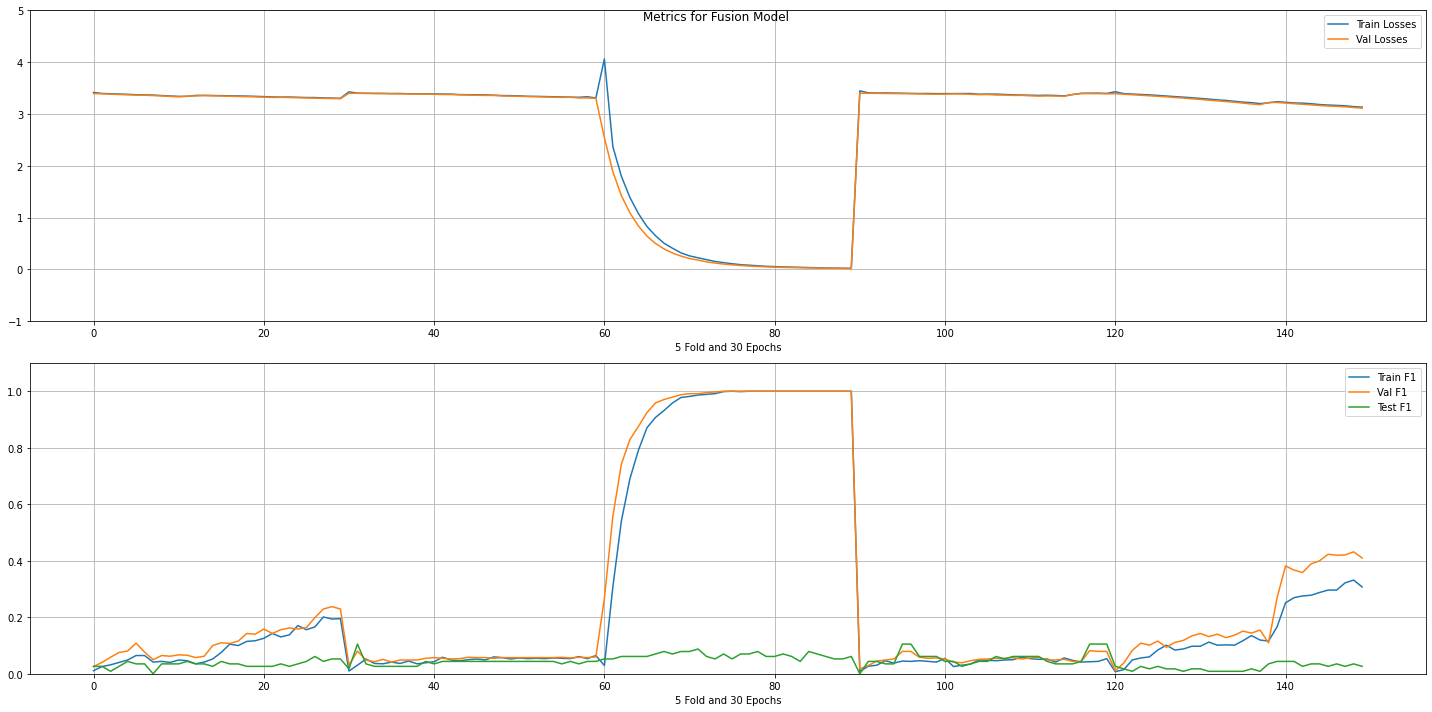

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.402107,0.737666,0.35,0.034302,0.055221,0.04386,0.366387,0.606053,0.324634


In [ ]:
sequences, attention_masks = get_seq_masks('google/muril-base-cased',txt)
muril_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MURIL_FineTuned',
                                gpu, 'google/muril-base-cased', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=N_EPOCHS, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [ ]:
display(HTML(results_to_df(muril_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
15,1.000000,1.000000,0.052632,1.000000,1.000000,0.052632,1.000000,1.000000,0.052632
17,1.000000,1.000000,0.070175,1.000000,1.000000,0.070175,1.000000,1.000000,0.070175
18,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947
19,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404
20,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404
21,1.000000,1.000000,0.070175,1.000000,1.000000,0.070175,1.000000,1.000000,0.070175
22,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404
23,1.000000,1.000000,0.043860,1.000000,1.000000,0.043860,1.000000,1.000000,0.043860
24,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947
25,1.000000,1.000000,0.070175,1.000000,1.000000,0.070175,1.000000,1.000000,0.070175


# XLM-R Fusion

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Class Weights : [0.85416667 2.62820513 2.27777778 1.36666667 2.44047619 3.41666667
 1.13888889 1.31410256 0.85416667 1.79824561 1.5530303  3.41666667
 0.75925926 0.55107527 2.84722222 1.2654321  1.2654321  1.70833333
 1.89814815 2.27777778 0.69727891 0.62121212 0.39272031 1.5530303
 0.53385417 1.10215054 0.57909605 0.43803419 4.27083333 0.41666667]
Epoch 1/30 : Training Loss: 3.674 / Validation Loss : 2.570 [Time : 25.442315 seconds]
Epoch 2/30 : Training Loss: 2.422 / Validation Loss : 1.975 [Time : 24.795982 seconds]
Epoch 3/30 : Training Loss: 1.872 / Validation Loss : 1.515 [Time : 24.849395 seconds]
Epoch 4/30 : Training Loss: 1.461 / Validation Loss : 1.174 [Time : 25.2165 seconds]
Epoch 5/30 : Training Loss: 1.141 / Validation Loss : 0.919 [Time : 24.936773 seconds]
Epoch 6/30 : Training Loss: 0.892 / Validation Loss : 0.723 [Time : 24.778663 seconds]
Epoch 7/30 : Training Loss: 0.712 / Validation Loss : 0.576 [Time : 25.241397 seconds]
Epoch 8/30 : Training Loss: 0.578 / Valida

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/30 : Training Loss: 3.635 / Validation Loss : 2.850 [Time : 20.081939 seconds]
Epoch 2/30 : Training Loss: 2.755 / Validation Loss : 2.331 [Time : 20.153408 seconds]
Epoch 3/30 : Training Loss: 2.239 / Validation Loss : 1.915 [Time : 20.010848 seconds]
Epoch 4/30 : Training Loss: 1.880 / Validation Loss : 1.574 [Time : 19.272306 seconds]
Epoch 5/30 : Training Loss: 1.558 / Validation Loss : 1.302 [Time : 19.239992 seconds]
Epoch 6/30 : Training Loss: 1.291 / Validation Loss : 1.075 [Time : 19.244831 seconds]
Epoch 7/30 : Training Loss: 1.070 / Validation Loss : 0.890 [Time : 19.254478 seconds]
Epoch 8/30 : Training Loss: 0.894 / Validation Loss : 0.740 [Time : 19.387731 seconds]
Epoch 9/30 : Training Loss: 0.742 / Validation Loss : 0.615 [Time : 19.335572 seconds]
Epoch 10/30 : Training Loss: 0.620 / Validation Loss : 0.513 [Time : 19.286714 seconds]
Epoch 11/30 : Training Loss: 0.520 / Validation Loss : 0.430 [Time : 19.302087 seconds]
Epoch 12/30 : Training Loss: 0.438 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/30 : Training Loss: 3.434 / Validation Loss : 3.400 [Time : 20.039639 seconds]
Epoch 2/30 : Training Loss: 3.404 / Validation Loss : 3.397 [Time : 19.907232 seconds]
Epoch 3/30 : Training Loss: 3.403 / Validation Loss : 3.394 [Time : 19.70648 seconds]
Epoch 4/30 : Training Loss: 3.397 / Validation Loss : 3.391 [Time : 19.283469 seconds]
Epoch 5/30 : Training Loss: 3.398 / Validation Loss : 3.387 [Time : 19.303275 seconds]
Epoch 6/30 : Training Loss: 3.393 / Validation Loss : 3.382 [Time : 19.270143 seconds]
Epoch 7/30 : Training Loss: 3.388 / Validation Loss : 3.377 [Time : 19.269069 seconds]
Epoch 8/30 : Training Loss: 3.383 / Validation Loss : 3.372 [Time : 19.403139 seconds]
Epoch 9/30 : Training Loss: 3.376 / Validation Loss : 3.363 [Time : 19.281301 seconds]
Epoch 10/30 : Training Loss: 3.369 / Validation Loss : 3.355 [Time : 19.308356 seconds]
Epoch 11/30 : Training Loss: 3.363 / Validation Loss : 3.348 [Time : 19.254948 seconds]
Epoch 12/30 : Training Loss: 3.351 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/30 : Training Loss: 3.456 / Validation Loss : 3.389 [Time : 19.948207 seconds]
Epoch 2/30 : Training Loss: 3.398 / Validation Loss : 3.376 [Time : 19.96352 seconds]
Epoch 3/30 : Training Loss: 3.386 / Validation Loss : 3.363 [Time : 19.393332 seconds]
Epoch 4/30 : Training Loss: 3.376 / Validation Loss : 3.353 [Time : 19.26358 seconds]
Epoch 5/30 : Training Loss: 3.366 / Validation Loss : 3.340 [Time : 19.33157 seconds]
Epoch 6/30 : Training Loss: 3.349 / Validation Loss : 3.325 [Time : 19.264307 seconds]
Epoch 7/30 : Training Loss: 3.338 / Validation Loss : 3.318 [Time : 19.238189 seconds]
Epoch 8/30 : Training Loss: 3.328 / Validation Loss : 3.301 [Time : 19.316666 seconds]
Epoch 9/30 : Training Loss: 3.310 / Validation Loss : 3.281 [Time : 19.230034 seconds]
Epoch 10/30 : Training Loss: 3.297 / Validation Loss : 3.264 [Time : 19.3225 seconds]
Epoch 11/30 : Training Loss: 3.280 / Validation Loss : 3.252 [Time : 19.23355 seconds]
Epoch 12/30 : Training Loss: 3.266 / Validation

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/30 : Training Loss: 3.911 / Validation Loss : 2.576 [Time : 19.991005 seconds]
Epoch 2/30 : Training Loss: 2.446 / Validation Loss : 1.939 [Time : 19.912702 seconds]
Epoch 3/30 : Training Loss: 1.818 / Validation Loss : 1.456 [Time : 19.228423 seconds]
Epoch 4/30 : Training Loss: 1.402 / Validation Loss : 1.101 [Time : 19.217636 seconds]
Epoch 5/30 : Training Loss: 1.068 / Validation Loss : 0.825 [Time : 24.120047 seconds]
Epoch 6/30 : Training Loss: 0.798 / Validation Loss : 0.616 [Time : 19.227388 seconds]
Epoch 7/30 : Training Loss: 0.620 / Validation Loss : 0.468 [Time : 19.235093 seconds]
Epoch 8/30 : Training Loss: 0.460 / Validation Loss : 0.354 [Time : 19.224266 seconds]
Epoch 9/30 : Training Loss: 0.352 / Validation Loss : 0.275 [Time : 19.210168 seconds]
Epoch 10/30 : Training Loss: 0.281 / Validation Loss : 0.221 [Time : 19.443455 seconds]
Epoch 11/30 : Training Loss: 0.224 / Validation Loss : 0.175 [Time : 19.265438 seconds]
Epoch 12/30 : Training Loss: 0.187 / Vali

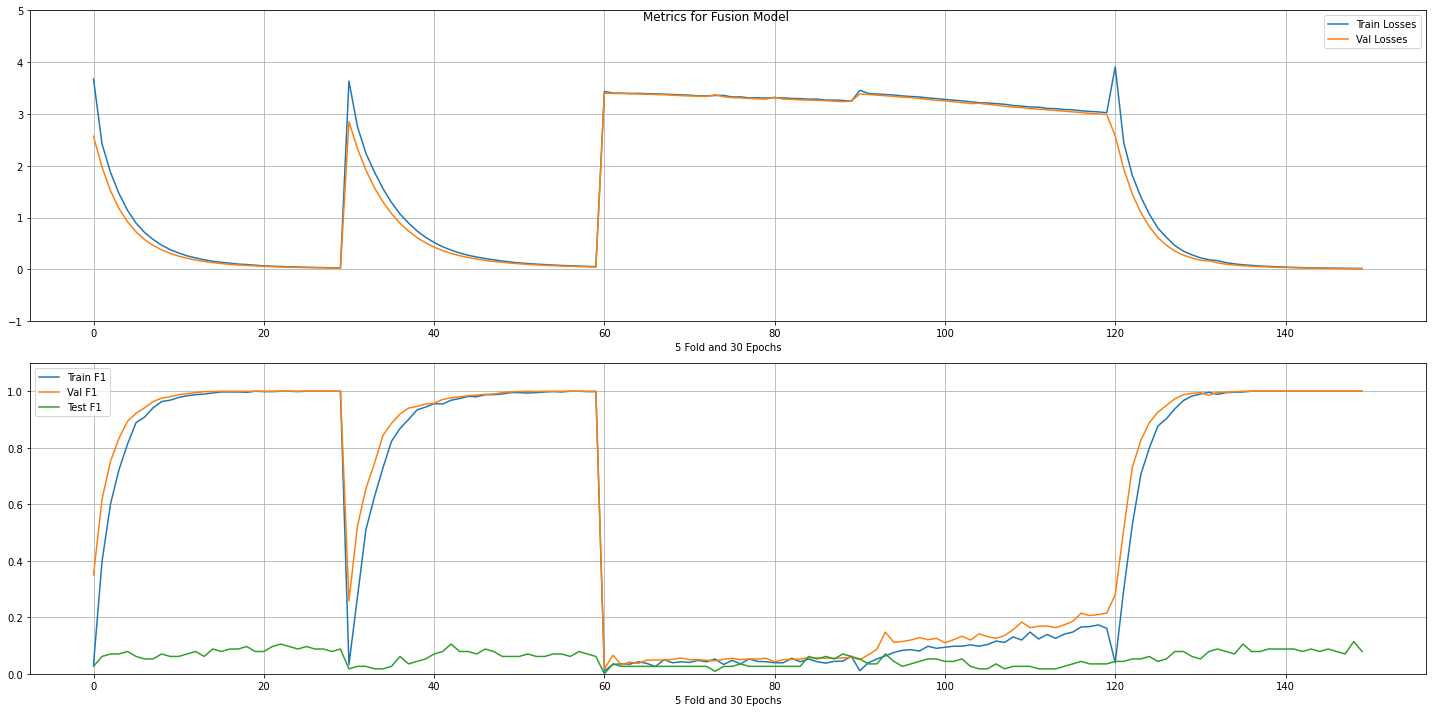

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.720401,0.888109,0.654146,0.056913,0.060779,0.066667,0.679339,0.799806,0.640976


In [ ]:
sequences, attention_masks = get_seq_masks('xlm-roberta-base',txt)
xlmr_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/XLMR_Finetuned',
                                gpu, 'xlm-roberta-base', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=N_EPOCHS, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [ ]:
display(HTML(results_to_df(xlmr_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
19,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947
22,1.000000,1.000000,0.105263,1.000000,1.000000,0.105263,1.000000,1.000000,0.105263
23,1.000000,1.000000,0.096491,1.000000,1.000000,0.096491,1.000000,1.000000,0.096491
25,1.000000,1.000000,0.096491,1.000000,1.000000,0.096491,1.000000,1.000000,0.096491
26,1.000000,1.000000,0.087719,1.000000,1.000000,0.087719,1.000000,1.000000,0.087719
27,1.000000,1.000000,0.087719,1.000000,1.000000,0.087719,1.000000,1.000000,0.087719
28,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947
29,1.000000,1.000000,0.087719,1.000000,1.000000,0.087719,1.000000,1.000000,0.087719
26,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404
27,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947


# MBERT Fusion

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.85416667 2.62820513 2.27777778 1.36666667 2.44047619 3.41666667
 1.13888889 1.31410256 0.85416667 1.79824561 1.5530303  3.41666667
 0.75925926 0.55107527 2.84722222 1.2654321  1.2654321  1.70833333
 1.89814815 2.27777778 0.69727891 0.62121212 0.39272031 1.5530303
 0.53385417 1.10215054 0.57909605 0.43803419 4.27083333 0.41666667]
Epoch 1/30 : Training Loss: 3.408 / Validation Loss : 3.385 [Time : 22.998418 seconds]
Epoch 2/30 : Training Loss: 3.384 / Validation Loss : 3.372 [Time : 21.926644 seconds]
Epoch 3/30 : Training Loss: 3.371 / Validation Loss : 3.357 [Time : 21.538872 seconds]
Epoch 4/30 : Training Loss: 3.356 / Validation Loss : 3.339 [Time : 21.515151 seconds]
Epoch 5/30 : Training Loss: 3.340 / Validation Loss : 3.327 [Time : 21.755353 seconds]
Epoch 6/30 : Training Loss: 3.329 / Validation Loss : 3.312 [Time : 21.576813 seconds]
Epoch 7/30 : Training Loss: 3.315 / Validation Loss : 3.303 [Time : 21.411005 seconds]
Epoch 8/30 : Training Loss: 3.310 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.472 / Validation Loss : 3.003 [Time : 21.893972 seconds]
Epoch 2/30 : Training Loss: 2.913 / Validation Loss : 2.643 [Time : 21.451838 seconds]
Epoch 3/30 : Training Loss: 2.551 / Validation Loss : 2.285 [Time : 21.553616 seconds]
Epoch 4/30 : Training Loss: 2.193 / Validation Loss : 1.951 [Time : 21.568568 seconds]
Epoch 5/30 : Training Loss: 1.887 / Validation Loss : 1.658 [Time : 21.57073 seconds]
Epoch 6/30 : Training Loss: 1.605 / Validation Loss : 1.407 [Time : 21.542396 seconds]
Epoch 7/30 : Training Loss: 1.370 / Validation Loss : 1.196 [Time : 21.6633 seconds]
Epoch 8/30 : Training Loss: 1.161 / Validation Loss : 1.016 [Time : 21.566825 seconds]
Epoch 9/30 : Training Loss: 0.983 / Validation Loss : 0.865 [Time : 21.523581 seconds]
Epoch 10/30 : Training Loss: 0.843 / Validation Loss : 0.736 [Time : 21.862979 seconds]
Epoch 11/30 : Training Loss: 0.723 / Validation Loss : 0.630 [Time : 21.81269 seconds]
Epoch 12/30 : Training Loss: 0.618 / Validati

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 8.345 / Validation Loss : 2.944 [Time : 18.606997 seconds]
Epoch 2/30 : Training Loss: 2.561 / Validation Loss : 1.479 [Time : 18.500205 seconds]
Epoch 3/30 : Training Loss: 1.496 / Validation Loss : 0.951 [Time : 18.184137 seconds]
Epoch 4/30 : Training Loss: 1.010 / Validation Loss : 0.634 [Time : 18.143536 seconds]
Epoch 5/30 : Training Loss: 0.706 / Validation Loss : 0.451 [Time : 18.119893 seconds]
Epoch 6/30 : Training Loss: 0.487 / Validation Loss : 0.337 [Time : 18.074361 seconds]
Epoch 7/30 : Training Loss: 0.392 / Validation Loss : 0.259 [Time : 23.972573 seconds]
Epoch 8/30 : Training Loss: 0.299 / Validation Loss : 0.207 [Time : 18.101118 seconds]
Epoch 9/30 : Training Loss: 0.236 / Validation Loss : 0.164 [Time : 18.195638 seconds]
Epoch 10/30 : Training Loss: 0.191 / Validation Loss : 0.134 [Time : 18.110166 seconds]
Epoch 11/30 : Training Loss: 0.154 / Validation Loss : 0.108 [Time : 18.114405 seconds]
Epoch 12/30 : Training Loss: 0.133 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 6.149 / Validation Loss : 2.493 [Time : 18.517312 seconds]
Epoch 2/30 : Training Loss: 2.201 / Validation Loss : 1.491 [Time : 18.430357 seconds]
Epoch 3/30 : Training Loss: 1.463 / Validation Loss : 0.993 [Time : 18.327495 seconds]
Epoch 4/30 : Training Loss: 1.002 / Validation Loss : 0.719 [Time : 18.061368 seconds]
Epoch 5/30 : Training Loss: 0.737 / Validation Loss : 0.536 [Time : 18.074008 seconds]
Epoch 6/30 : Training Loss: 0.551 / Validation Loss : 0.411 [Time : 18.061538 seconds]
Epoch 7/30 : Training Loss: 0.439 / Validation Loss : 0.323 [Time : 19.603622 seconds]
Epoch 8/30 : Training Loss: 0.353 / Validation Loss : 0.259 [Time : 18.062461 seconds]
Epoch 9/30 : Training Loss: 0.276 / Validation Loss : 0.211 [Time : 18.073342 seconds]
Epoch 10/30 : Training Loss: 0.229 / Validation Loss : 0.178 [Time : 18.05822 seconds]
Epoch 11/30 : Training Loss: 0.194 / Validation Loss : 0.148 [Time : 18.100583 seconds]
Epoch 12/30 : Training Loss: 0.167 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 8.798 / Validation Loss : 2.487 [Time : 18.518294 seconds]
Epoch 2/30 : Training Loss: 2.230 / Validation Loss : 1.179 [Time : 18.439105 seconds]
Epoch 3/30 : Training Loss: 1.211 / Validation Loss : 0.677 [Time : 18.194098 seconds]
Epoch 4/30 : Training Loss: 0.751 / Validation Loss : 0.434 [Time : 18.109955 seconds]
Epoch 5/30 : Training Loss: 0.468 / Validation Loss : 0.291 [Time : 18.06147 seconds]
Epoch 6/30 : Training Loss: 0.328 / Validation Loss : 0.209 [Time : 18.066692 seconds]
Epoch 7/30 : Training Loss: 0.237 / Validation Loss : 0.157 [Time : 18.068922 seconds]
Epoch 8/30 : Training Loss: 0.200 / Validation Loss : 0.134 [Time : 18.096421 seconds]
Epoch 9/30 : Training Loss: 0.151 / Validation Loss : 0.099 [Time : 18.116312 seconds]
Epoch 10/30 : Training Loss: 0.130 / Validation Loss : 0.085 [Time : 18.064358 seconds]
Epoch 11/30 : Training Loss: 0.103 / Validation Loss : 0.067 [Time : 18.09026 seconds]
Epoch 12/30 : Training Loss: 0.085 / Valida

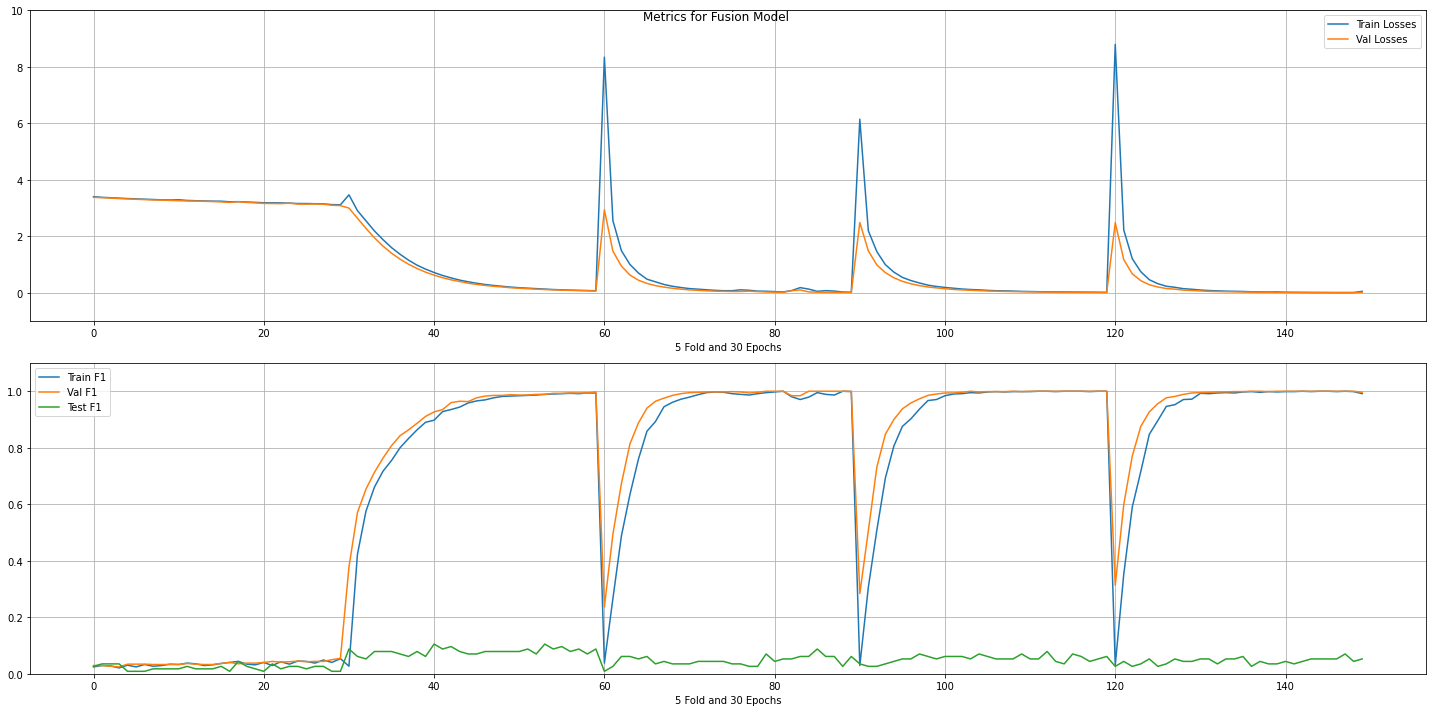

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.85367,0.938164,0.810488,0.049246,0.049563,0.052632,0.836145,0.892345,0.809024


In [28]:
sequences, attention_masks = get_seq_masks('bert-base-multilingual-cased',txt)
mbert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MBERT_Finetuned',
                                gpu, 'bert-base-multilingual-cased', n_labels=n_labels,feature='mel_spec', title='Fusion Model',
                                epochs=N_EPOCHS, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [29]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
21,1.000000,1.000000,0.052632,1.000000,1.000000,0.052632,1.000000,1.000000,0.052632
28,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
21,1.000000,1.000000,0.052632,1.000000,1.000000,0.052632,1.000000,1.000000,0.052632
22,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947,1.000000,1.000000,0.078947
24,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
25,1.000000,1.000000,0.070175,1.000000,1.000000,0.070175,1.000000,1.000000,0.070175
26,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404
28,1.000000,1.000000,0.052632,1.000000,1.000000,0.052632,1.000000,1.000000,0.052632
29,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404,1.000000,1.000000,0.061404
22,1.000000,1.000000,0.043860,1.000000,1.000000,0.043860,1.000000,1.000000,0.043860
